In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
import os

from torch import nn
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from timeit import default_timer as timer 
from tqdm.auto import tqdm

from imblearn.over_sampling import SMOTE
from torchsampler import ImbalancedDatasetSampler

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
# Setup paths
data_path = Path("data/")
image_path = data_path / "view_dset_01_splitted/cc_splitted/"

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/view_dset_01_splitted/cc_splitted/train'),
 WindowsPath('data/view_dset_01_splitted/cc_splitted/test'))

In [24]:
num_train_img = len(os.listdir(train_dir))
for set_dir in os.listdir(image_path):
    set_dir_path = image_path / set_dir
    for class_dir in os.listdir(set_dir_path):
        class_dir_path = set_dir_path / class_dir
        print(f"{class_dir_path}: {len(os.listdir(class_dir_path))}")

data\view_dset_01_splitted\cc_splitted\test\0: 5240
data\view_dset_01_splitted\cc_splitted\test\1: 114
data\view_dset_01_splitted\cc_splitted\test_prep\0: 5240
data\view_dset_01_splitted\cc_splitted\test_prep\1: 114
data\view_dset_01_splitted\cc_splitted\train\0: 6000
data\view_dset_01_splitted\cc_splitted\train\1: 452
data\view_dset_01_splitted\cc_splitted\train_prep\0: 20959
data\view_dset_01_splitted\cc_splitted\train_prep\1: 452


In [25]:
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights = torchvision.models.ResNet50_Weights.DEFAULT

In [26]:
#model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model = torchvision.models.resnet50(weights=weights).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize,
                                        transforms.Grayscale(num_output_channels=1) # For 1 channel image
                                        ])

In [29]:
""" import torchvision.datasets as datasets
from torch.utils.data import WeightedRandomSampler

dset = datasets.ImageFolder(train_dir, transform=manual_transforms)

class_weights = [1, 4]
sample_weights = [0] * len(dset)

for idx, (data, label) in enumerate(dset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True) """
# train_loader= DataLoader(
#       dset,
#       batch_size=16,
#       num_workers= os.cpu_count(),
#       sampler=sampler )


' import torchvision.datasets as datasets\nfrom torch.utils.data import WeightedRandomSampler\n\ndset = datasets.ImageFolder(train_dir, transform=manual_transforms)\n\nclass_weights = [1, 4]\nsample_weights = [0] * len(dset)\n\nfor idx, (data, label) in enumerate(dset):\n    class_weight = class_weights[label]\n    sample_weights[idx] = class_weight\n\nsampler = WeightedRandomSampler(sample_weights, \n                                num_samples=len(sample_weights),\n                                replacement=True) '

In [31]:
from util.util_dset import create_dataloaders, create_dataloaders_with_smote_aug

BATCH_SIZE = 8

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders_with_smote_aug(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms, # perform same data transforms on our own data as the pretrained model
                                                                    batch_size=BATCH_SIZE,
                                                                    sampling_strategy=0.70
                                                                    ) # set mini-batch size to 32

print("Batch size: ", BATCH_SIZE)
print("Number of train batches:",len(train_dataloader))
print("Number of test batches:",len(test_dataloader))

print("Number of classes: ",len(class_names))
print("Classes: ", class_names)


Counter({tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, tensor(0.): 1, t

In [32]:
# freeze the base layers
for param in model.parameters():
    param.requires_grad = False

In [33]:
# make input one channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), 
                       stride=(2, 2), padding=(3, 3), bias=False)

In [34]:
# Update the classsifier head of our model

DROPOUT_PROB = 0.1
IN_FEATURES = 2048 # EfficientNet_B0: 1280 | ResNet50: 2048

torch.manual_seed(42)
torch.cuda.manual_seed(42)

""" model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT_PROB, inplace=True),
    nn.Linear(in_features=IN_FEATURES, out_features=len(class_names))
).to(device) """

# For ResNet
model.fc = nn.Sequential(
    nn.Dropout(p=DROPOUT_PROB, inplace=True),
    nn.Linear(in_features=IN_FEATURES, out_features=len(class_names))
).to(device)

In [35]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

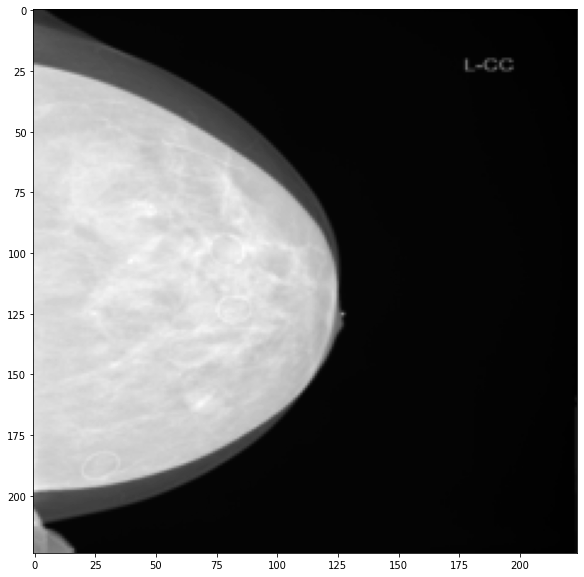

In [36]:
from PIL import Image
image = next(iter(train_dataloader))[0][0]
#image = torch.nn.functional.normalize(image)
plt.figure(figsize = (10,10))
plt.imshow(image.permute(1,2,0), cmap="gray")
#torchvision.utils.save_image(torch.nn.functional.normalize(image), fp="./smoted.png")
#torchvision.io.write_png(torch.nn.functional.normalize(image.type(torch.uint8)), filename="./smoted.png")
#im = Image.fromarray(image)
#im.save("./", "png")

In [37]:
torchinfo.summary(model=model, 
        input_size=(8, 1, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

c:\Users\rainm\miniconda3\envs\pytorch2\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\rainm\miniconda3\envs\pytorch2\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [8, 1, 224, 224]     [8, 2]               --                   Partial
├─Conv2d (conv1)                         [8, 1, 224, 224]     [8, 64, 112, 112]    3,136                True
├─BatchNorm2d (bn1)                      [8, 64, 112, 112]    [8, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [8, 64, 112, 112]    [8, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [8, 64, 112, 112]    [8, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [8, 64, 56, 56]      [8, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [8, 64, 56, 56]      [8, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [8, 64, 56, 56]      [8, 64, 56, 56]      (4,096)              False
│    │    └

In [38]:
import engine

LR = 0.00001
NUM_EPOCHS = 10
TEST_NAME = "ResNet50_NOAUG_NOPREP_NOEXT"
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device,
                log_txt_saver=True,
                save_model = False,
                test_name = TEST_NAME
                )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:26<12:54, 86.09s/it]

Epoch: 1 | train_loss: 0.6235 | train_acc: 0.6718 | test_loss: 0.4405 | test_acc: 0.9776


 20%|██        | 2/10 [02:51<11:27, 85.95s/it]

Epoch: 2 | train_loss: 0.5842 | train_acc: 0.6907 | test_loss: 0.4459 | test_acc: 0.9681


 30%|███       | 3/10 [04:17<10:01, 85.99s/it]

Epoch: 3 | train_loss: 0.5620 | train_acc: 0.7091 | test_loss: 0.3994 | test_acc: 0.9532


 40%|████      | 4/10 [05:44<08:36, 86.03s/it]

Epoch: 4 | train_loss: 0.5460 | train_acc: 0.7261 | test_loss: 0.3949 | test_acc: 0.9233


 50%|█████     | 5/10 [07:10<07:10, 86.17s/it]

Epoch: 5 | train_loss: 0.5344 | train_acc: 0.7401 | test_loss: 0.4097 | test_acc: 0.9013


 60%|██████    | 6/10 [08:36<05:44, 86.08s/it]

Epoch: 6 | train_loss: 0.5239 | train_acc: 0.7482 | test_loss: 0.3885 | test_acc: 0.9086


 70%|███████   | 7/10 [10:02<04:18, 86.12s/it]

Epoch: 7 | train_loss: 0.5206 | train_acc: 0.7542 | test_loss: 0.3910 | test_acc: 0.9030


 80%|████████  | 8/10 [11:28<02:52, 86.12s/it]

Epoch: 8 | train_loss: 0.5114 | train_acc: 0.7549 | test_loss: 0.4101 | test_acc: 0.8765


 90%|█████████ | 9/10 [12:54<01:26, 86.15s/it]

Epoch: 9 | train_loss: 0.5090 | train_acc: 0.7616 | test_loss: 0.4127 | test_acc: 0.8696


100%|██████████| 10/10 [14:20<00:00, 86.09s/it]

Epoch: 10 | train_loss: 0.5014 | train_acc: 0.7692 | test_loss: 0.4032 | test_acc: 0.9032
[INFO] Total training time: 860.911 seconds


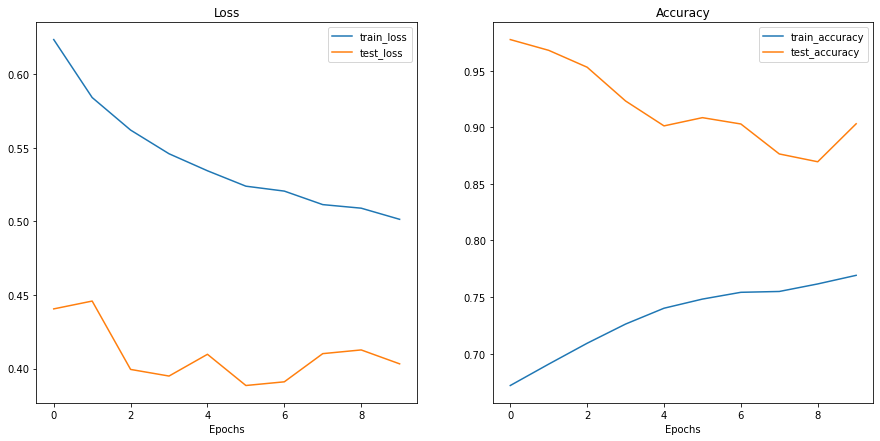

In [42]:
from util.util_plot import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [40]:
test_preds = []

model.to(device)
model.eval()

start_time_testset = timer()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    test_logits = model(X)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = timer()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} (s).")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([y for X, y in test_dataloader])

100%|██████████| 670/670 [00:47<00:00, 14.25it/s]


Total testing time: 47.749 (s).


Main Parameters of model:Batch size: 8 
Epochs: 10 
Learning Rate: 1e-05 
Dropout Prob: 0.1 
Training time: 47.749


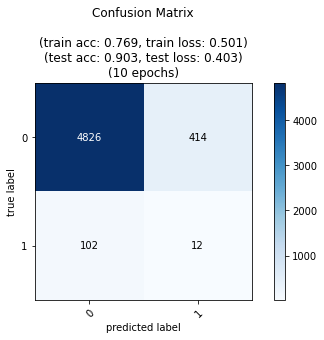

In [43]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=class_names,
    figsize=(8, 4),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(results['train_acc'][NUM_EPOCHS-1],3)
last_train_loss = round(results['train_loss'][NUM_EPOCHS-1],3)
last_test_acc = round(results['test_acc'][NUM_EPOCHS-1],3)
last_test_loss = round(results['test_loss'][NUM_EPOCHS-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({NUM_EPOCHS} epochs)"
    )

print(f"Main Parameters of model:"+ 
      f"Batch size: {BATCH_SIZE} \n"+
      f"Epochs: {NUM_EPOCHS} \n"+
      f"Learning Rate: {LR} \n"+
      f"Dropout Prob: {DROPOUT_PROB} \n"+
      f"Training time: {end_time_testset-start_time_testset:.3f}"
      )